## Loading the dataset into a TF pipeline

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2152 files belonging to 3 classes.


# Get the class name

In [5]:
classnames = data.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for batch_image, batch_labels in data.take(1):
    print(batch_image.shape)
    print(batch_labels.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


# Visualizing the dataset

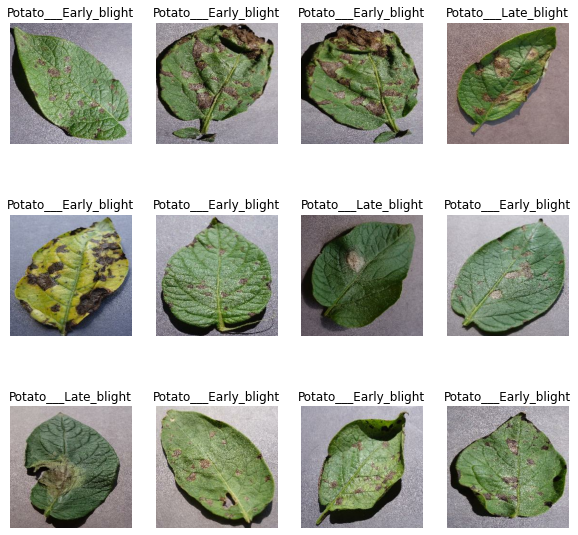

In [7]:
plt.figure(figsize=(10, 10))
for batch_image, batch_labels in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(batch_image[i].numpy().astype("uint8"))
        plt.title(classnames[batch_labels[i]])
        plt.axis("off")

## Function to Split Dataset
### Dataset should be divided into 3 subsets, namely:

#### Training: Dataset to be used while training
#### Validation: Dataset to be tested against while training
#### Test: Dataset to be tested against after we trained a model

In [8]:
train_data_size = 0.8
len(data)*train_data_size


54.400000000000006

## Creating the Trainset

In [9]:
train_data = data.take(54)
len(train_data)

54

## Creating the Testset

In [10]:
test_data = data.skip(54)
len(test_data)

14

In [11]:
val_data = test_data.take(6)
len(val_data)

6

In [12]:
def get_dataset_partitions_tf(data, val_split=0.1, train_split=0.8, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    data_size = len(data)
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_data = data.take(train_size)    
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data

In [13]:
train_data, val_data, test_data = get_dataset_partitions_tf(data)

In [14]:
len(train_data)

54

In [15]:
len(val_data)

6

In [16]:
len(test_data)

8

## Cache the image for the next iteration
### Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing and model design

#### Below we are resizing the image and normalizing the pixels so that while training and inference. This way, we can improve the model performance. 

In [18]:
rescale_and_resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augementation helps to inrease the data size and also helps the model learn the inputs easily.

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Model Creation using CNN

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    rescale_and_resize,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 62s 1s/step - loss: 0.9201 - accuracy: 0.4578 - val_loss: 0.8547 - val_accuracy: 0.4896
Epoch 2/20
54/54 [==============================] - 61s 1s/step - loss: 0.7918 - accuracy: 0.5856 - val_loss: 0.7086 - val_accuracy: 0.6719
Epoch 3/20
54/54 [==============================] - 57s 1s/step - loss: 0.5598 - accuracy: 0.7541 - val_loss: 0.4734 - val_accuracy: 0.7917
Epoch 4/20
54/54 [==============================] - 66s 1s/step - loss: 0.3870 - accuracy: 0.8339 - val_loss: 0.2805 - val_accuracy: 0.8594
Epoch 5/20
54/54 [==============================] - 60s 1s/step - loss: 0.2742 - accuracy: 0.8877 - val_loss: 0.2486 - val_accuracy: 0.8698
Epoch 6/20
54/54 [==============================] - 59s 1s/step - loss: 0.2043 - accuracy: 0.9196 - val_loss: 0.1674 - val_accuracy: 0.9167
Epoch 7/20
54/54 [==============================] - 63s 1s/step - loss: 0.1435 - accuracy: 0.9479 - val_loss: 0.1433 - val_accuracy: 0.9323
Epoch 8/20
54/54 [==

In [25]:
model.save("Potato_Disease_Classifier.h5")

In [26]:
scores = model.evaluate(test_data)

8/8 [==============================] - 3s 260ms/step - loss: 0.0447 - accuracy: 0.9961


In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
print('Accuracy: \n', acc)
print('\nVal accuracy: \n', val_acc)
print('\nLoss: \n', loss)
print('\nVal loss: \n', val_loss)

Accuracy: 
 [0.45775464177131653, 0.5856481194496155, 0.7540509104728699, 0.8339120149612427, 0.8877314925193787, 0.9195601940155029, 0.9479166865348816, 0.9589120149612427, 0.9583333134651184, 0.9456018805503845, 0.9774305820465088, 0.9901620149612427, 0.9890046119689941, 0.9780092835426331, 0.9953703880310059, 0.9982638955116272, 0.9641203880310059, 0.9861111044883728, 0.9965277910232544, 1.0]

Val accuracy: 
 [0.4895833432674408, 0.671875, 0.7916666865348816, 0.859375, 0.8697916865348816, 0.9166666865348816, 0.9322916865348816, 0.9114583134651184, 0.9635416865348816, 0.9427083134651184, 0.9739583134651184, 0.9947916865348816, 0.96875, 0.9895833134651184, 1.0, 0.9791666865348816, 0.9583333134651184, 0.984375, 0.984375, 0.9791666865348816]

Loss: 
 [0.9201216697692871, 0.7917729020118713, 0.5598247647285461, 0.38697999715805054, 0.27420714497566223, 0.20427840948104858, 0.14349476993083954, 0.10799935460090637, 0.1156611368060112, 0.13144434988498688, 0.06901295483112335, 0.0395320951

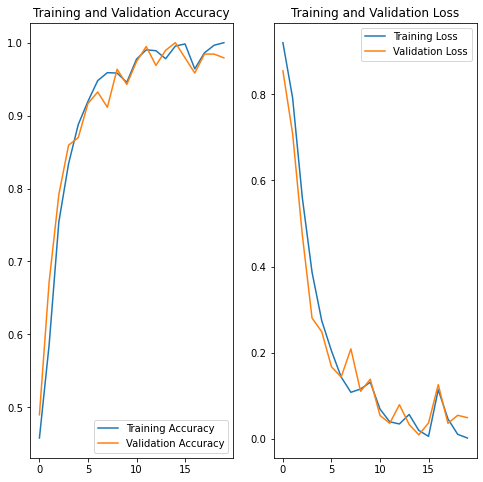

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


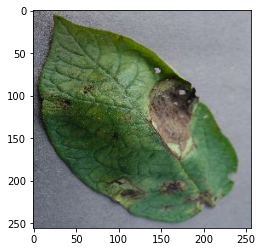

In [32]:
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

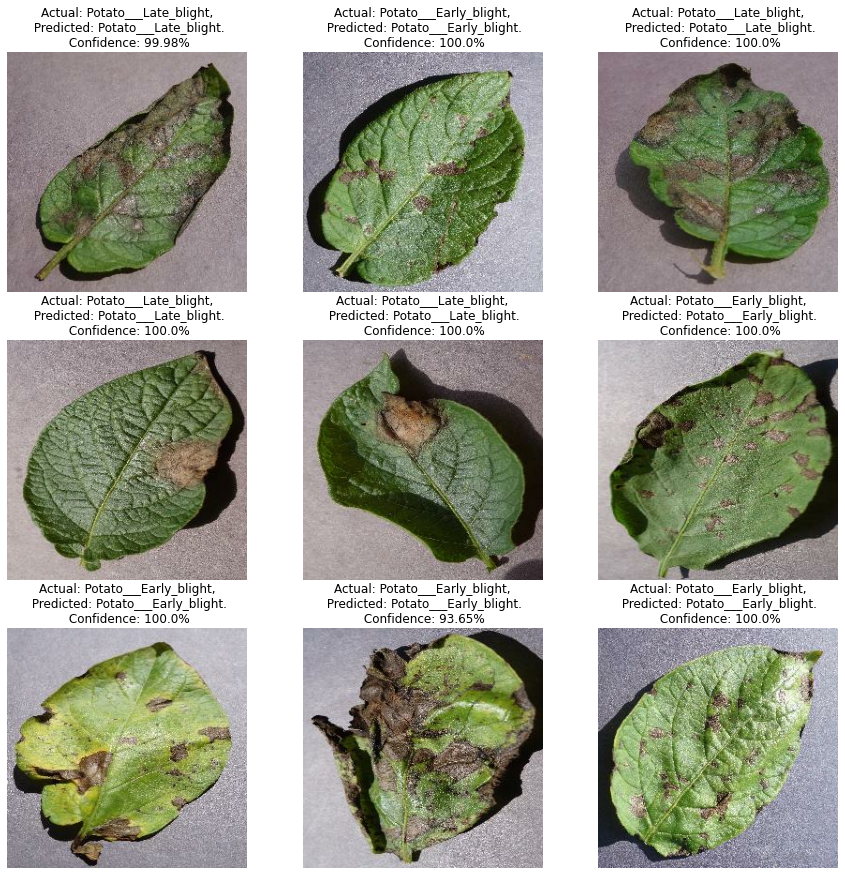

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classnames[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")